In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 
from dotenv import load_dotenv 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MaxAbsScaler


In [2]:
import psycopg2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [5]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [6]:
query_main=query="""
    select * 
    from agg.tidy_data_final
    where site = 20
    AND timestamp <= '2020-03-27 00:00:00+00'::timestamp with time zone
"""
df_main = pd.read_sql_query(query_main, conn)


In [7]:
pd.set_option('display.max_columns', None)

df_main

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
0,2019-04-13 00:00:00+00:00,20,2019,4,13,1,0,5,2,13.99,0.0,3.0,112.0,11.0,0.0,0.0,218.21,14.81,147.15,28.43,1
1,2019-04-01 00:00:00+00:00,20,2019,4,1,1,0,0,2,198.79,0.0,2.0,87.0,12.0,0.0,0.0,156.18,15.32,140.56,18.91,0
2,2019-04-01 00:30:00+00:00,20,2019,4,1,1,30,0,2,250.51,0.0,2.0,87.0,12.0,0.0,0.0,209.12,15.26,173.26,18.79,0
3,2019-04-01 01:00:00+00:00,20,2019,4,1,2,0,0,2,194.07,0.0,3.0,89.0,11.0,0.0,0.0,219.51,15.86,194.07,41.08,0
4,2019-04-01 01:30:00+00:00,20,2019,4,1,2,30,0,2,245.33,0.0,3.0,89.0,11.0,0.0,0.0,214.43,15.87,181.63,57.84,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,2019-05-23 17:30:00+00:00,20,2019,5,23,18,30,3,2,-44.75,0.0,14.0,268.0,8.0,104.0,44.0,-5.27,-78.15,16.27,8.11,0
17325,2019-05-23 18:00:00+00:00,20,2019,5,23,19,0,3,2,2.33,0.0,13.0,267.0,8.0,58.0,44.0,89.53,-5.71,31.11,10.70,0
17326,2019-05-23 18:30:00+00:00,20,2019,5,23,19,30,3,2,5.29,0.0,13.0,267.0,8.0,58.0,44.0,86.43,1.38,19.98,14.04,0
17327,2019-05-23 19:00:00+00:00,20,2019,5,23,20,0,3,2,18.06,0.0,12.0,266.0,7.0,19.0,41.0,62.93,11.78,23.62,15.77,0


In [8]:
df_main = df_main[['timestamp','net_load','month', 'day', 'hour', 'day_of_week', 'season', 'avg_net_load','weekend_or_bank_holiday','solar_radiation','sunshine_duration', "precipitation_probability"]]
df_main

,timestamp,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,precipitation_probability
0,2019-04-13 00:00:00+00:00,13.99,4,13,1,5,2,218.21,1,0.0,0.0,3.0
1,2019-04-01 00:00:00+00:00,198.79,4,1,1,0,2,156.18,0,0.0,0.0,2.0
2,2019-04-01 00:30:00+00:00,250.51,4,1,1,0,2,209.12,0,0.0,0.0,2.0
3,2019-04-01 01:00:00+00:00,194.07,4,1,2,0,2,219.51,0,0.0,0.0,3.0
4,2019-04-01 01:30:00+00:00,245.33,4,1,2,0,2,214.43,0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17324,2019-05-23 17:30:00+00:00,-44.75,5,23,18,3,2,-5.27,0,104.0,44.0,14.0
17325,2019-05-23 18:00:00+00:00,2.33,5,23,19,3,2,89.53,0,58.0,44.0,13.0
17326,2019-05-23 18:30:00+00:00,5.29,5,23,19,3,2,86.43,0,58.0,44.0,13.0
17327,2019-05-23 19:00:00+00:00,18.06,5,23,20,3,2,62.93,0,19.0,41.0,12.0


### Convert Convert 'ts' to datetime and set as index

In [9]:
df_main.rename(columns={'timestamp':'ts'},inplace=True)
df_main['ts'] = pd.to_datetime(df_main['ts'])
df_main.set_index('ts', inplace=True)
df_main.sort_index(inplace=True)
df_main.head()

,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,precipitation_probability
ts,,,,,,,,,,,
2019-04-01 00:00:00+00:00,198.79,4,1,1,0,2,156.18,0,0.0,0.0,2.0
2019-04-01 00:30:00+00:00,250.51,4,1,1,0,2,209.12,0,0.0,0.0,2.0
2019-04-01 01:00:00+00:00,194.07,4,1,2,0,2,219.51,0,0.0,0.0,3.0
2019-04-01 01:30:00+00:00,245.33,4,1,2,0,2,214.43,0,0.0,0.0,3.0
2019-04-01 02:00:00+00:00,223.68,4,1,3,0,2,235.79,0,0.0,0.0,4.0


### Normalise net_load, avg_net_load, precipitation_probability, solar_radiation, and sunshine_duration


In [10]:
#Normalise net_load, avg_net_load, precipitation_probability, solar_radiation, and sunshine_duration using MAXABS scaler
scaler = MaxAbsScaler()
df_main[['net_load_norm','avg_net_load_norm','precipitation_probability_norm','solar_radiation_norm','sunshine_duration_norm']] = scaler.fit_transform(df_main[['net_load','avg_net_load','precipitation_probability','solar_radiation','sunshine_duration']])

df_main

,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,precipitation_probability,net_load_norm,avg_net_load_norm,precipitation_probability_norm,solar_radiation_norm,sunshine_duration_norm
ts,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,198.79,4,1,1,0,2,156.18,0,0.0,0.0,2.0,0.124297,0.095949,0.02,0.0,0.0
2019-04-01 00:30:00+00:00,250.51,4,1,1,0,2,209.12,0,0.0,0.0,2.0,0.156635,0.128473,0.02,0.0,0.0
2019-04-01 01:00:00+00:00,194.07,4,1,2,0,2,219.51,0,0.0,0.0,3.0,0.121345,0.134856,0.03,0.0,0.0
2019-04-01 01:30:00+00:00,245.33,4,1,2,0,2,214.43,0,0.0,0.0,3.0,0.153396,0.131735,0.03,0.0,0.0
2019-04-01 02:00:00+00:00,223.68,4,1,3,0,2,235.79,0,0.0,0.0,4.0,0.139859,0.144857,0.04,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 22:00:00+00:00,289.54,3,26,23,3,2,296.75,0,0.0,0.0,1.0,0.181039,0.182308,0.01,0.0,0.0
2020-03-26 22:30:00+00:00,270.53,3,26,23,3,2,318.98,0,0.0,0.0,1.0,0.169153,0.195965,0.01,0.0,0.0
2020-03-26 23:00:00+00:00,271.85,3,27,0,4,2,326.67,0,0.0,0.0,1.0,0.169978,0.200689,0.01,0.0,0.0


<Axes: xlabel='ts'>

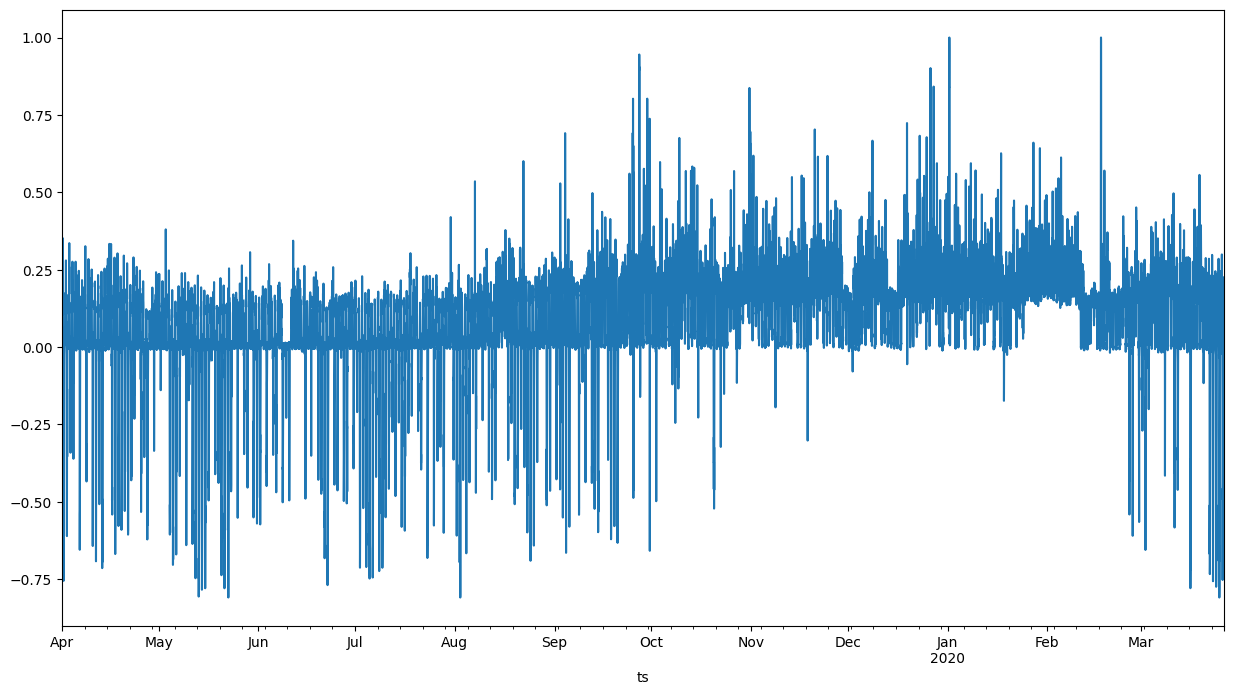

In [11]:
plt.figure(figsize=(15,8))
df_main['net_load_norm'].plot()

In [12]:
df_main.head()

,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,precipitation_probability,net_load_norm,avg_net_load_norm,precipitation_probability_norm,solar_radiation_norm,sunshine_duration_norm
ts,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,198.79,4,1,1,0,2,156.18,0,0.0,0.0,2.0,0.124297,0.095949,0.02,0.0,0.0
2019-04-01 00:30:00+00:00,250.51,4,1,1,0,2,209.12,0,0.0,0.0,2.0,0.156635,0.128473,0.02,0.0,0.0
2019-04-01 01:00:00+00:00,194.07,4,1,2,0,2,219.51,0,0.0,0.0,3.0,0.121345,0.134856,0.03,0.0,0.0
2019-04-01 01:30:00+00:00,245.33,4,1,2,0,2,214.43,0,0.0,0.0,3.0,0.153396,0.131735,0.03,0.0,0.0
2019-04-01 02:00:00+00:00,223.68,4,1,3,0,2,235.79,0,0.0,0.0,4.0,0.139859,0.144857,0.04,0.0,0.0


## Creating function for lagged net_load

In [13]:
#Creating function for lagged net_load

def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'net_load_lag_{lag}'] = df_lagged['net_load_norm'].shift(lag)
    # Remove rows with NaN values due to shifting
    
    return df_lagged

# Define lags
lags = [1,2,3,4,5,48,96]


# Prepare dataset with lagged features
df_lagged = create_lagged_features(df_main, lags)

df_lagged

,net_load,month,day,hour,day_of_week,season,avg_net_load,weekend_or_bank_holiday,solar_radiation,sunshine_duration,precipitation_probability,net_load_norm,avg_net_load_norm,precipitation_probability_norm,solar_radiation_norm,sunshine_duration_norm,net_load_lag_1,net_load_lag_2,net_load_lag_3,net_load_lag_4,net_load_lag_5,net_load_lag_48,net_load_lag_96
ts,,,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,198.79,4,1,1,0,2,156.18,0,0.0,0.0,2.0,0.124297,0.095949,0.02,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 00:30:00+00:00,250.51,4,1,1,0,2,209.12,0,0.0,0.0,2.0,0.156635,0.128473,0.02,0.0,0.0,0.124297,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 01:00:00+00:00,194.07,4,1,2,0,2,219.51,0,0.0,0.0,3.0,0.121345,0.134856,0.03,0.0,0.0,0.156635,0.124297,NaN,NaN,NaN,NaN,NaN
2019-04-01 01:30:00+00:00,245.33,4,1,2,0,2,214.43,0,0.0,0.0,3.0,0.153396,0.131735,0.03,0.0,0.0,0.121345,0.156635,0.124297,NaN,NaN,NaN,NaN
2019-04-01 02:00:00+00:00,223.68,4,1,3,0,2,235.79,0,0.0,0.0,4.0,0.139859,0.144857,0.04,0.0,0.0,0.153396,0.121345,0.156635,0.124297,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 22:00:00+00:00,289.54,3,26,23,3,2,296.75,0,0.0,0.0,1.0,0.181039,0.182308,0.01,0.0,0.0,0.179220,0.226259,0.155322,0.021096,0.011167,0.161337,0.204437
2020-03-26 22:30:00+00:00,270.53,3,26,23,3,2,318.98,0,0.0,0.0,1.0,0.169153,0.195965,0.01,0.0,0.0,0.181039,0.179220,0.226259,0.155322,0.021096,0.172711,0.178570
2020-03-26 23:00:00+00:00,271.85,3,27,0,4,2,326.67,0,0.0,0.0,1.0,0.169978,0.200689,0.01,0.0,0.0,0.169153,0.181039,0.179220,0.226259,0.155322,0.162031,0.169672


## Create initial_ts by taking the last 96 observations (48 hours) from this point backward to cover all lags

(Previously took the last 192 observations of 15 minute-intervalls (48 hours) from this point backward to cover all lags)

In [14]:
#Select a subset of df_lagge to be the set of data that the rolling prediction function will use to start making predictions

end_time = df_lagged.index[-1]
start_time = end_time - pd.Timedelta(hours=24)  # 192 intervals of 15 minutes is equivalent to 48 hours / Should i not be using 36 hours?

if start_time < df_lagged.index[0]:
    raise ValueError("Not enough data points for the required lags.")

# Create for rolling predictions

initial_ts = df_lagged.loc[start_time:end_time]['net_load_norm']

In [15]:
initial_ts

ts
2020-03-26 00:00:00+00:00    0.160368
2020-03-26 00:30:00+00:00    0.159605
2020-03-26 01:00:00+00:00    0.136220
2020-03-26 01:30:00+00:00    0.160212
2020-03-26 02:00:00+00:00    0.186911
2020-03-26 02:30:00+00:00    0.149639
2020-03-26 03:00:00+00:00    0.155697
2020-03-26 03:30:00+00:00    0.142179
2020-03-26 04:00:00+00:00    0.216936
2020-03-26 04:30:00+00:00    0.299152
2020-03-26 05:00:00+00:00    0.201004
2020-03-26 05:30:00+00:00    0.148194
2020-03-26 06:00:00+00:00   -0.011667
2020-03-26 06:30:00+00:00   -0.010792
2020-03-26 07:00:00+00:00   -0.021315
2020-03-26 07:30:00+00:00   -0.003445
2020-03-26 08:00:00+00:00   -0.007547
2020-03-26 08:30:00+00:00   -0.006928
2020-03-26 09:00:00+00:00   -0.014944
2020-03-26 09:30:00+00:00   -0.648882
2020-03-26 10:00:00+00:00   -0.752670
2020-03-26 10:30:00+00:00   -0.622252
2020-03-26 11:00:00+00:00   -0.457738
2020-03-26 11:30:00+00:00   -0.491978
2020-03-26 12:00:00+00:00   -0.479991
2020-03-26 12:30:00+00:00   -0.480548
2020-03-2

## Define train and test sets 

In [16]:
features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3', 'net_load_lag_4', 'net_load_lag_5', 
            'net_load_lag_48', 'net_load_lag_96', 'month', 'day', 'hour', 'day_of_week', 'season', 
            'avg_net_load_norm', 'weekend_or_bank_holiday', 'solar_radiation_norm', 'sunshine_duration_norm', 'precipitation_probability_norm']

In [17]:
#X = df_lagged[[f'net_load_lag_{lag}' for lag in lags]]
X = df_lagged[features]
y = df_lagged['net_load_norm']

# Reserve the last 72 observations for testing - 36 hours
train_features = X.iloc[:-72]
test_features = X.iloc[-72:]

train_target = y.iloc[:-72]
test_target = y.iloc[-72:]

In [18]:
print(train_features.shape)
print(test_target.shape)

(17257, 17)
(72,)


### Model definition and training 

In [19]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)

## Create get_input functions

#### 1. get_lags_input (get lagged values of net_load_norm)
#### 2. get_other_features_input (get other features' values at the index/timestamp we are predicting for)
#### 3. get_prediction_input (combine 1 and 2)


#### 1. get_lags_input 

In [20]:
#get_timestamp_input

def get_lags_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [- lag for lag in lags]
    # Use iloc to get values at positions
    return ts.iloc[positions].values.reshape(1, -1)

#### 2. get_other_features_input
1. Define new df = df_other_features from the train_features set (which includes lagged net_load values as well) and remove lagged values
2. Add back later on lagged values cthrough the get_input function to account for their updates 

In [21]:
df_other_features = test_features.drop(test_features.columns[test_features.columns.str.startswith('net_load_lag')], axis = 1)
df_other_features.tail()

,month,day,hour,day_of_week,season,avg_net_load_norm,weekend_or_bank_holiday,solar_radiation_norm,sunshine_duration_norm,precipitation_probability_norm
ts,,,,,,,,,,
2020-03-26 22:00:00+00:00,3,26,23,3,2,0.182308,0,0.0,0.0,0.01
2020-03-26 22:30:00+00:00,3,26,23,3,2,0.195965,0,0.0,0.0,0.01
2020-03-26 23:00:00+00:00,3,27,0,4,2,0.200689,0,0.0,0.0,0.01
2020-03-26 23:30:00+00:00,3,27,0,4,2,0.194472,0,0.0,0.0,0.01
2020-03-27 00:00:00+00:00,3,27,1,4,2,0.225030,0,0.0,0.0,0.01


In [22]:
def get_other_features_input(other_features, index):
    return other_features.loc[index].values.reshape(1, -1)

#### 3. get_prediction_input (combine 1 and 2)

In [23]:
def get_prediction_input(ts, other_features, lags):
    input_lags = get_lags_input(ts, lags)
    index = ts.index[-1] + pd.Timedelta(minutes=30)
    
    input_features = get_other_features_input(other_features, index)
    
    return np.concatenate((input_lags, input_features), axis = 1)

### Rolling origin prediction

Create a function that performs sequential predictions over a specified number of steps, using each prediction as input for the next

In [24]:
def rolling_window_predictions(model, full_series, other_features, n, lags):
    
    initial_ts = full_series.copy() # Initial time series for rolling predictions    
    predictions = []  # Store out-of-sample predictions
    
    for i in range(0, n): # Iterate over the test set to predict one step ahead each time
        
        input_features = get_prediction_input(initial_ts, other_features, lags) # Get input features for current prediction

        pred = model.predict(input_features)[0] # Predict the next time step and store the prediction
        predictions.append(pred)
        
        # Append actual observed value to roll the window forward
        new_index = initial_ts.index[-1] + pd.Timedelta(minutes=30)

        print("new_index: ", new_index)
        
        initial_ts.loc[new_index] = pred
    
    return predictions


In [25]:
prediction_test=rolling_window_predictions(rf, train_target, df_other_features, 72, lags)

new_index:  2020-03-25 12:30:00+00:00
new_index:  2020-03-25 13:00:00+00:00
new_index:  2020-03-25 13:30:00+00:00
new_index:  2020-03-25 14:00:00+00:00
new_index:  2020-03-25 14:30:00+00:00
new_index:  2020-03-25 15:00:00+00:00
new_index:  2020-03-25 15:30:00+00:00
new_index:  2020-03-25 16:00:00+00:00
new_index:  2020-03-25 16:30:00+00:00
new_index:  2020-03-25 17:00:00+00:00
new_index:  2020-03-25 17:30:00+00:00
new_index:  2020-03-25 18:00:00+00:00
new_index:  2020-03-25 18:30:00+00:00
new_index:  2020-03-25 19:00:00+00:00
new_index:  2020-03-25 19:30:00+00:00
new_index:  2020-03-25 20:00:00+00:00
new_index:  2020-03-25 20:30:00+00:00
new_index:  2020-03-25 21:00:00+00:00
new_index:  2020-03-25 21:30:00+00:00
new_index:  2020-03-25 22:00:00+00:00
new_index:  2020-03-25 22:30:00+00:00
new_index:  2020-03-25 23:00:00+00:00
new_index:  2020-03-25 23:30:00+00:00
new_index:  2020-03-26 00:00:00+00:00
new_index:  2020-03-26 00:30:00+00:00
new_index:  2020-03-26 01:00:00+00:00
new_index:  

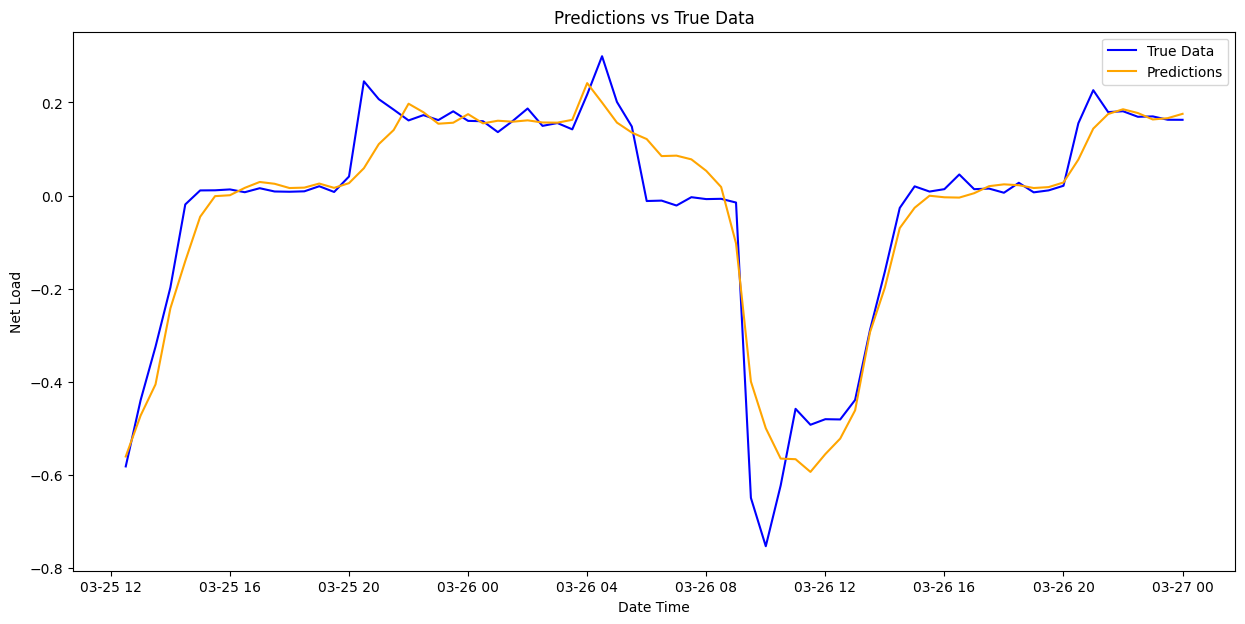

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(test_target.index, test_target, label='True Data', color='blue')
plt.plot(test_target.index, prediction_test, label='Predictions', color='orange')

plt.title('Predictions vs True Data')
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.legend()
plt.show()


## Implement the rolling window predictions with the new function

## Re-define train + test to include 30 days for test

In [27]:
X = df_lagged[features]
y = df_lagged['net_load_norm']


In [28]:
test_split_date = '2020-02-24 00:00:00+00:00'

train_features = X.loc[X.index < test_split_date]
train_target = y.loc[y.index < test_split_date]

test_features = X.loc[X.index >= test_split_date]
test_target = y.loc[y.index >= test_split_date]

In [29]:
df_other_features_2 = test_features.drop(test_features.columns[test_features.columns.str.startswith('net_load_lag')], axis = 1)
df_other_features_2.tail()

,month,day,hour,day_of_week,season,avg_net_load_norm,weekend_or_bank_holiday,solar_radiation_norm,sunshine_duration_norm,precipitation_probability_norm
ts,,,,,,,,,,
2020-03-26 22:00:00+00:00,3,26,23,3,2,0.182308,0,0.0,0.0,0.01
2020-03-26 22:30:00+00:00,3,26,23,3,2,0.195965,0,0.0,0.0,0.01
2020-03-26 23:00:00+00:00,3,27,0,4,2,0.200689,0,0.0,0.0,0.01
2020-03-26 23:30:00+00:00,3,27,0,4,2,0.194472,0,0.0,0.0,0.01
2020-03-27 00:00:00+00:00,3,27,1,4,2,0.225030,0,0.0,0.0,0.01


In [30]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)

In [31]:
def nested_prediction_model(model, input_ts, other_features, true_data, n_shifts, n_steps, n_days, lags=[1,2,3,4,5,48,96] ):
    full_predictions = []
    ts = input_ts.copy()
    
# Iterate over each day in the test data
    for day in range(0, n_days):
        
        # Make predictions for the current day
        print("predicting day: ", day)
        pred_day = rolling_window_predictions(model, ts, other_features, n_steps, lags)

        # Append the day's predictions to the full predictions
        full_predictions.extend(pred_day[n_shifts:])

        # update true values
        true_values = true_data[day*(n_steps-n_shifts) : (day+1)*(n_steps-n_shifts)]
    

        ts = pd.concat([ts, pd.Series(true_values)]) # Update ts by appending the true values

    return full_predictions



In [32]:
n_shifts = 24
n_steps = 72
n_days = 31

In [33]:
# Input ts as train_target and append the first n_shifts values of test_target
input_ts = pd.concat([train_target, test_target.iloc[:n_shifts]])

In [34]:
input_ts

ts
2019-04-01 00:00:00+00:00    0.124297
2019-04-01 00:30:00+00:00    0.156635
2019-04-01 01:00:00+00:00    0.121345
2019-04-01 01:30:00+00:00    0.153396
2019-04-01 02:00:00+00:00    0.139859
                               ...   
2020-02-24 09:30:00+00:00    0.129405
2020-02-24 10:00:00+00:00    0.029356
2020-02-24 10:30:00+00:00    0.133232
2020-02-24 11:00:00+00:00    0.184122
2020-02-24 11:30:00+00:00    0.078765
Name: net_load_norm, Length: 15816, dtype: float64

In [35]:
full_predictions=nested_prediction_model(rf, input_ts, df_other_features_2, test_target[n_shifts:], n_shifts, n_steps, n_days, lags=[1,2,3,4,5,48,96])


predicting day:  0
new_index:  2020-02-24 12:00:00+00:00
new_index:  2020-02-24 12:30:00+00:00
new_index:  2020-02-24 13:00:00+00:00
new_index:  2020-02-24 13:30:00+00:00
new_index:  2020-02-24 14:00:00+00:00
new_index:  2020-02-24 14:30:00+00:00
new_index:  2020-02-24 15:00:00+00:00
new_index:  2020-02-24 15:30:00+00:00
new_index:  2020-02-24 16:00:00+00:00
new_index:  2020-02-24 16:30:00+00:00
new_index:  2020-02-24 17:00:00+00:00
new_index:  2020-02-24 17:30:00+00:00
new_index:  2020-02-24 18:00:00+00:00
new_index:  2020-02-24 18:30:00+00:00
new_index:  2020-02-24 19:00:00+00:00
new_index:  2020-02-24 19:30:00+00:00
new_index:  2020-02-24 20:00:00+00:00
new_index:  2020-02-24 20:30:00+00:00
new_index:  2020-02-24 21:00:00+00:00
new_index:  2020-02-24 21:30:00+00:00
new_index:  2020-02-24 22:00:00+00:00
new_index:  2020-02-24 22:30:00+00:00
new_index:  2020-02-24 23:00:00+00:00
new_index:  2020-02-24 23:30:00+00:00
new_index:  2020-02-25 00:00:00+00:00
new_index:  2020-02-25 00:30:00

new_index:  2020-02-25 08:30:00+00:00
new_index:  2020-02-25 09:00:00+00:00
new_index:  2020-02-25 09:30:00+00:00
new_index:  2020-02-25 10:00:00+00:00
new_index:  2020-02-25 10:30:00+00:00
new_index:  2020-02-25 11:00:00+00:00
new_index:  2020-02-25 11:30:00+00:00
new_index:  2020-02-25 12:00:00+00:00
new_index:  2020-02-25 12:30:00+00:00
new_index:  2020-02-25 13:00:00+00:00
new_index:  2020-02-25 13:30:00+00:00
new_index:  2020-02-25 14:00:00+00:00
new_index:  2020-02-25 14:30:00+00:00
new_index:  2020-02-25 15:00:00+00:00
new_index:  2020-02-25 15:30:00+00:00
new_index:  2020-02-25 16:00:00+00:00
new_index:  2020-02-25 16:30:00+00:00
new_index:  2020-02-25 17:00:00+00:00
new_index:  2020-02-25 17:30:00+00:00
new_index:  2020-02-25 18:00:00+00:00
new_index:  2020-02-25 18:30:00+00:00
new_index:  2020-02-25 19:00:00+00:00
new_index:  2020-02-25 19:30:00+00:00
new_index:  2020-02-25 20:00:00+00:00
new_index:  2020-02-25 20:30:00+00:00
new_index:  2020-02-25 21:00:00+00:00
new_index:  

In [36]:
len(test_target)

1537

In [37]:
# set test target plot as the true values from (n_steps - n_shifts) to (ndays + 1)*(n_steps - n_shifts)

test_target_plot = test_target.iloc[n_steps- n_shifts: (n_days + 1)*(n_steps - n_shifts)]

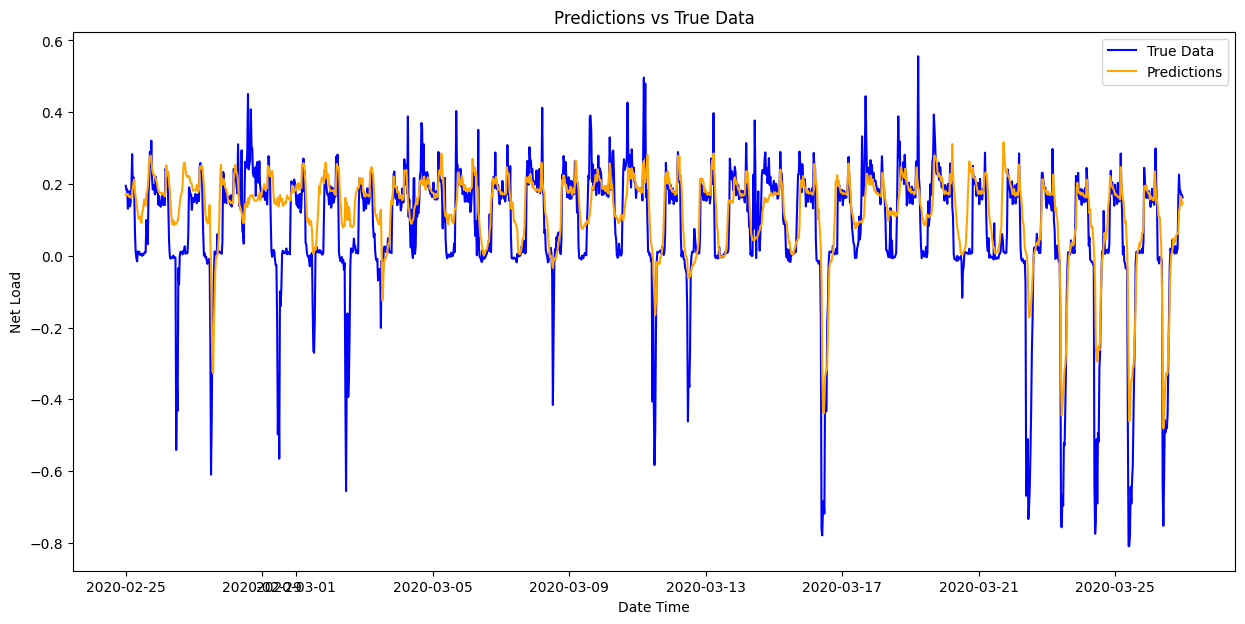

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(test_target_plot.index, test_target_plot, label='True Data', color='blue')

plt.plot(test_target_plot.index, full_predictions, label='Predictions', color='orange')

plt.title('Predictions vs True Data')
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.legend()
plt.show()


## MAE, MSE, and RMSE

#### Test

In [46]:
# print the MAE, MSE and RMSE for the test 
mae_test = mean_absolute_error(test_target_plot, full_predictions)
mse_test = mean_squared_error(test_target_plot, full_predictions)
rmse_test = np.sqrt(mse_test)

print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)



Test MAE: 0.07585593202448951
Test MSE: 0.015109563158625992
Test RMSE: 0.12292096305604668


### Train

In [47]:
# print the MAE, MSE and RMSE for the train
train_predictions = rf.predict(train_features)
mae_train = mean_absolute_error(train_target, train_predictions)
mse_train = mean_squared_error(train_target, train_predictions)
rmse_train = np.sqrt(mse_train)

print("Test MAE:", mae_train)
print("Test MSE:", mse_train)
print("Test RMSE:", rmse_train)

Test MAE: 0.013320937643279787
Test MSE: 0.0005638170733458827
Test RMSE: 0.023744832560914864


## PLOT parts of the predictions:
#### Convert full_predictions to a pandas Series and add a DateTimeIndex that matches the index of test_target_plot

In [41]:
full_predictions_series = pd.Series(full_predictions, index=pd.date_range(start='2020-03-01', periods=len(full_predictions), freq='30T'))
# Now filter the predictions and actual values to the date range
start_date = '2020-03-01'
end_date = '2020-03-07'
plot_predictions = full_predictions_series[start_date:end_date]
plot_actual = test_target_plot[start_date:end_date]

plot_actual

ts
2020-03-01 00:00:00+00:00    0.144937
2020-03-01 00:30:00+00:00    0.139616
2020-03-01 01:00:00+00:00    0.168242
2020-03-01 01:30:00+00:00    0.133450
2020-03-01 02:00:00+00:00    0.170335
                               ...   
2020-03-07 21:30:00+00:00    0.231236
2020-03-07 22:00:00+00:00    0.242491
2020-03-07 22:30:00+00:00    0.203136
2020-03-07 23:00:00+00:00    0.208876
2020-03-07 23:30:00+00:00    0.198322
Name: net_load_norm, Length: 336, dtype: float64

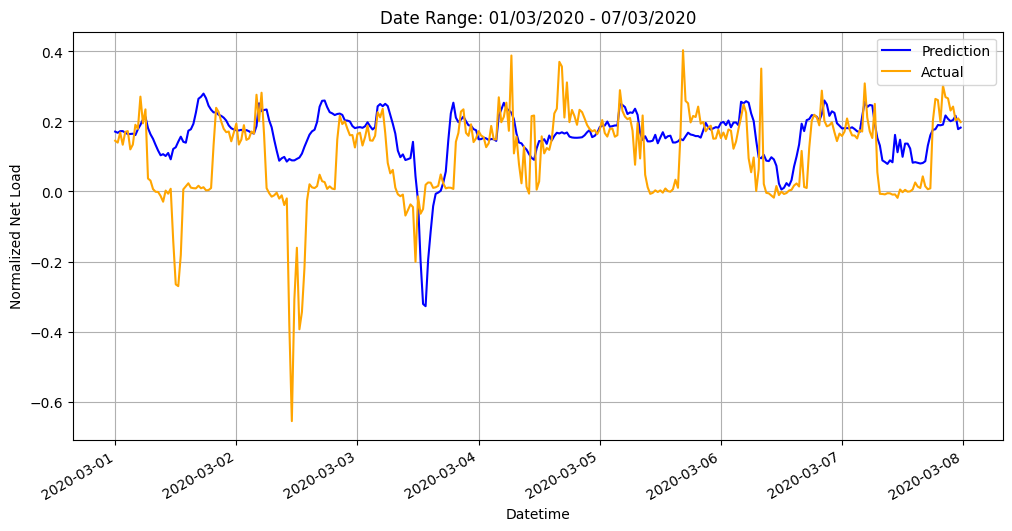

In [42]:
# Define the date format for the x-axis
plt.figure(figsize=(12, 6))
plt.plot(plot_predictions.index, plot_predictions, label='Prediction', color='blue', linewidth=1.5)
plt.plot(plot_actual.index, plot_actual, label='Actual', color='orange', linewidth=1.5)

# Define the date format for the x-axis and rotate for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add grid, title, labels, and legend
plt.grid(visible=True)
plt.title('Date Range: 01/03/2020 - 07/03/2020')
plt.xlabel('Datetime')
plt.ylabel('Normalized Net Load')
plt.legend()

# Show plot
plt.show()

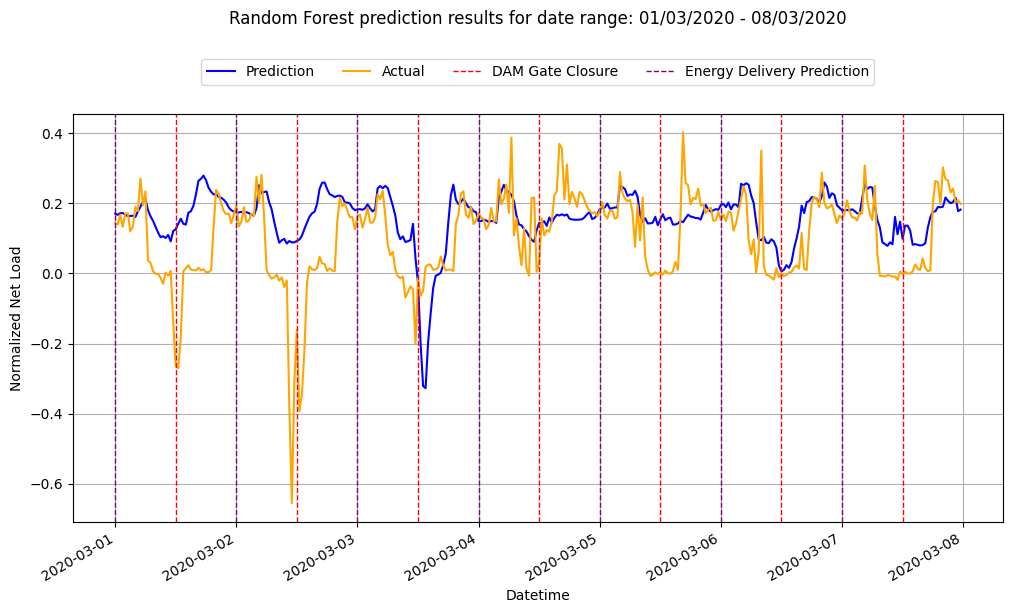

In [44]:
# Define the date format for the x-axis
plt.figure(figsize=(12, 6))
plt.plot(plot_predictions.index, plot_predictions, label='Prediction', color='blue', linewidth=1.5)
plt.plot(plot_actual.index, plot_actual, label='Actual', color='orange', linewidth=1.5)

for day in pd.date_range(start=start_date, end=end_date):
    dam_closure_time = pd.Timestamp(day.strftime('%Y-%m-%d 12:00'))
    energy_delivery_time = pd.Timestamp(day.strftime('%Y-%m-%d 00:00'))
    plt.axvline(x=dam_closure_time, color='red', linestyle='--', linewidth=1, label='DAM Gate Closure' if day == pd.Timestamp(start_date) else "")
    plt.axvline(x=energy_delivery_time, color='purple', linestyle='--', linewidth=1, label='Energy Delivery Prediction' if day == pd.Timestamp(start_date) else "")

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid(visible=True)
plt.title('Random Forest prediction results for date range: 01/03/2020 - 08/03/2020', y=1.20)
plt.xlabel('Datetime')
plt.ylabel('Normalized Net Load')

plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.show()

In [45]:
plot_predictions.to_csv('plot_predictions_RF.csv')
plot_actual.to_csv('plot_actual_RF.csv')

### . 

### . 

In [ ]:
def process_site_data(site_id):
    query_main=query="""
        select * 
        from agg.tidy_data_final
        where site = site_id
        AND timestamp <= '2020-03-27 00:00:00+00'::timestamp with time zone
    """
    df_main = pd.read_sql_query(query_main, conn)

    df_main = df_main[['timestamp','net_load','month', 'day', 'hour', 'day_of_week', 'season', 'avg_net_load','weekend_or_bank_holiday','solar_radiation','sunshine_duration', "precipitation_probability"]]

    ### Convert Convert 'ts' to datetime and set as index

    df_main.rename(columns={'timestamp':'ts'},inplace=True)
    df_main['ts'] = pd.to_datetime(df_main['ts'])
    df_main.set_index('ts', inplace=True)
    df_main.sort_index(inplace=True)

    #### Normalise net_load, avg_net_load, precipitation_probability, solar_radiation, and sunshine_duration

    scaler = MaxAbsScaler()
    df_main[['net_load_norm','avg_net_load_norm','precipitation_probability_norm','solar_radiation_norm','sunshine_duration_norm']] = scaler.fit_transform(df_main[['net_load','avg_net_load','precipitation_probability','solar_radiation','sunshine_duration']])

    
    ## Create initial_ts by taking the last 96 observations (48 hours) from this point backward to cover all lags

    end_time = df_lagged.index[-1]
    start_time = end_time - pd.Timedelta(hours=24)  # 192 intervals of 15 minutes is equivalent to 48 hours

    # Make sure you don't go out of bounds
    if start_time < df_lagged.index[0]:
        raise ValueError("Not enough data points for the required lags.")

    # Rolling predictions
    # Data between 'start_time' and 'end_time', including all necessary lags.
    initial_ts = df_lagged.loc[start_time:end_time]['net_load_norm']

    features = ['net_load_lag_1', 'net_load_lag_2', 'net_load_lag_3', 'net_load_lag_4', 'net_load_lag_5', 
            'net_load_lag_48', 'net_load_lag_96', 'month', 'day', 'hour', 'day_of_week', 'season', 
            'avg_net_load_norm', 'weekend_or_bank_holiday', 'solar_radiation_norm', 'sunshine_duration_norm', 'precipitation_probability_norm']
    
    ####### Define Train and Test set
         
    X = df_lagged[features]
    y = df_lagged['net_load_norm']

    test_split_date = '2020-02-24 00:00:00+00:00'

    train_features = X.loc[X.index < test_split_date]
    train_target = y.loc[y.index < test_split_date]

    test_features = X.loc[X.index >= test_split_date]
    test_target = y.loc[y.index >= test_split_date]

    df_other_features_2 = test_features.drop(test_features.columns[test_features.columns.str.startswith('net_load_lag')], axis = 1)

    ##### Run RF model 
    rf = RandomForestRegressor()

    # TRAIN the model
    rf.fit(train_features, train_target)

    # TEST the model - Predict on the test set
    y_pred = rf.predict(test_features)

    n_shifts = 24
    n_steps = 72
    n_days = 31

    # Set input ts as train_target and append the first n_shifts values of test_target
    input_ts = pd.concat([train_target, test_target.iloc[:n_shifts]])

    full_predictions=nested_prediction_model(rf, input_ts, df_other_features_2, test_target[n_shifts:], n_shifts, n_steps, n_days, lags=[1,2,3,4,5,48,96])

    test_target_plot = test_target.iloc[n_steps- n_shifts: (n_days + 1)*(n_steps - n_shifts)]

    plt.figure(figsize=(15, 7))
    plt.plot(test_target_plot.index, test_target_plot, label='True Data', color='blue')
    plt.plot(test_target_plot.index, full_predictions, label='Predictions', color='orange')

    plt.title('Predictions vs True Data')
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.legend()
    plt.show()

    # print the MAE, MSE and RMSE for the test 
    mae_test = mean_absolute_error(test_target_plot, full_predictions)
    mse_test = mean_squared_error(test_target_plot, full_predictions)
    rmse_test = np.sqrt(mse_test)

    print("Test MAE:", mae_test)
    print("Test MSE:", mse_test)
    print("Test RMSE:", rmse_test)

    # print the MAE, MSE and RMSE for the train
    train_predictions = rf.predict(train_features)
    mae_train = mean_absolute_error(train_target, train_predictions)
    mse_train = mean_squared_error(train_target, train_predictions)
    rmse_train = np.sqrt(mse_train)

    print("Train MAE:", mae_train)
    print("Train MSE:", mse_train)
    print("Train RMSE:", rmse_train)

  
    pass